# Activity 6.3 KMeans with Spark
In this activity we implement K-means Clustering algorithm with Map-Reduce using Spark and Python 2. This activity helps you to complete Assignment 4.

## Libraries
Let's start with loading the required libraries.

In [1]:
from __future__ import print_function
import numpy as np
from pyspark import SparkContext
from operator import add # for adding in reduce and reduceByKey 
import matplotlib.pyplot as plt

## Auxiliary Function
Before going further, let's define an auxiliary function that gets a datapoint `x`, list of cluster centers `mu` and the number of clusters `K`. The objective of this function is to calculate the distance between `x` and each cluster center in `mu`, then assign `x` to its nearest cluster center. We will call this function several times.

In [4]:
# finds the closest cluster center (mu) to each point x
def cluster(x, mu, K):
    dist = range(K)  # range K will return values from 0:value of range example range(4) -> [0,1,2,3]
    for i in range(K):
        dist[i] = np.sum((x - mu[i]) ** 2)  ## Sum of squares
    return np.argmin(dist)  # return the minimum squared error INDEX - note this is the index not the value

## Data
Now, we take a quick look at the data set that we are going to use here. 

In [5]:
!head ./irisK.csv

Let's initiate Spark and then load and partition our data file. We also need to converet the strings (each `line`) into `float` numbers.

In [6]:
sc.stop() # just in case there is something running in background!

# initiates a Spark Context object
sc = SparkContext(appName="KMeans")
    
# reads the input files and devides it into partitions
file = "./irisK.csv"
lines = sc.textFile(file)

Each element in `lines` is a string equvalent to one of the lines in the input file. We need to converet these strings to float numbers.

In [7]:
# converet each line of the text data file into a NumPy Array of float numbers
data = lines.map(lambda line: np.array([float(l) for l in line.split(',')])).cache()

# This code is effectively taking each line in the file (i.e. map item) and then running the split function based on , to 
# create a list of string values. These values are then converted one by one into a float in a loop and stored. Finally
# they are converted in an np array. The long way would be:

# for line in line:
    # floatl = []
    #l = line.split(',')
    #for l in l:
        # floatl.append(float(l))
    #np.array(floatl)
    
# The shorter version is much easier to write and understand


Now we have our data stored in `data` RDD. Each element of `data` is a NumPy vector of float numbers.

## KMeans
### Initialization
We need to set the number of clustes `K`, the maximum number of iterations `max_i` and the minimum threshold for progress at each iteration `prgrs_min`. By progress, we mean the sum of the distances between the current location of cluster centers and their previous locations. The value of `prgrs` can be used as a measure of convergence.

In [8]:
K = 3   # number of clusters
max_i = 100
i = 0
prgrs_min = float(0.001) # stopping threshold
prgrs = [float('+inf')]

The cluster centers should be initialized as well. As before, we randomly select `K` samples from the data as the initial cluster centers.

In [9]:
# randomly selects K data points from data as initial cluster centers
mu = data.takeSample(withReplacement=False, num=K, seed=1234)
print(mu)

[array([5.2, 4.1, 1.5, 0.1]), array([5. , 3.5, 1.3, 0.3]), array([5.2, 3.4, 1.4, 0.2])]


### KMeans Steps
Before doing the actual clustering, let's take a few moments to review the main steps of Map-Reduce KMeans. 
#### 1: Cluster the Points
The first thing we should do, is to find all data points that are associated to each particular cluster center. We need this information to be able to update the cluster centers by recalculating the average of their datapoints.  

Recall that we previously defined `cluster` function that assigns each datapoint `x` to its nearest cluster center. Therefore, if we execute `data.map(lambda point: cluster(point, mu, K))` we can map every datapoints to the index of the cluster it belongs to. However, It is not enough; we need to calculate the sum and the total numebr of the points grouped by the cluster index. Therefore, we map each datapoint `x` to a triple `<index, x, 1>` where `index` is the cluster index. The following line performs this task (Note that`.collect()[1:6]` is added to the end to only display the 6 first element):

In [10]:
indx_point_one = data.map(lambda x: (cluster(x, mu, K), (x, 1)))  # remember from earlier that 1 is often assigned as the value
                                                                    # because these can be summed by the aggregator
indx_point_one.collect()[1:6]

[(2, (array([4.9, 3. , 1.4, 0.2]), 1)),
 (1, (array([4.7, 3.2, 1.3, 0.2]), 1)),
 (1, (array([4.6, 3.1, 1.5, 0.2]), 1)),
 (1, (array([5. , 3.6, 1.4, 0.2]), 1)),
 (0, (array([5.4, 3.9, 1.7, 0.4]), 1))]

#### 2) Cluster Size and Summation
Since the `index` for all datapoints of a particular cluster is unique, our reducer can group the points that belong to each cluster, and then compute their sum (by adding all `x`s) and total number (by summation over all `1`s). We can easily do this task using `reduceByKey` function:

In [12]:
indx_sum_num = indx_point_one.reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))  # see markdown cell for details
indx_sum_num.collect()

[(0, (array([71.7, 47.1, 33. ,  9.3]), 12)),
 (2, (array([705.1, 342.3, 501.7, 165. ]), 117)),
 (1, (array([99.7, 68.7, 29.1,  5.5]), 21))]

Note that in the above expression, `x1[0]` is the datapoint array (i.e., `x` value from the triple) while `x1[1]` is always `1` (the last value in the triple). Each element of `indx_sum_num` has two parts. The first part is the cluster index, while the second part is an array containing the sum (as a vector) and the total number of datapoints (as single integer). 

#### 3) Cluster Mean
Now we can calculate cluster means by dividing the cluster sums to the cluster sizes:

In [18]:
## Recall that each elemebt of indx_sum_num renamed to sum_num in the lambda function is a tuple of 3 elements
## where the 2nd element (index=1) is an array and can also be index referrenced. Therefore we see that sum_num[1][0]
## refers to the first element which is the full array stored in sum_num and sum_num[1][1] refers to the second which is the 
## count N. In effect, each element in the middle array is divided by the number of points
indx_mu = indx_sum_num.map(lambda sum_num: (sum_num[0], sum_num[1][0] / sum_num[1][1]))
indx_mu.collect()

[(0, array([5.975, 3.925, 2.75 , 0.775])),
 (2, array([6.02649573, 2.92564103, 4.28803419, 1.41025641])),
 (1, array([4.74761905, 3.27142857, 1.38571429, 0.26190476]))]

When the new cluster centers have been found by we should update the `mu` matrix and check whether the convergence criterion has been met. 

### KMeans Loop
Let's put all these steps together and run our KMeans.

In [19]:
for i in range(max_i) :
    prgrs.append(float('+inf'))
    ## for each point find the closest cluster centerand returns <clusterIndex, point, 1>
    indx_point_one = data.map(lambda x: (cluster(x, mu, K), (x, 1)))  ## as above running the cluster over each
    
    ## for each cluster calculate the sum and the total number of its points
    indx_sum_num = indx_point_one.reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))

    ## for each cluster  - perform the calculation to get the new centers
    indx_mu = indx_sum_num.map(lambda sum_num: (sum_num[0], sum_num[1][0] / sum_num[1][1])).collect()

   
    ## update mu
    prgrs[i] = 0
    for (iK, iMu) in indx_mu:
        prgrs[i] += np.sum((mu[iK] - iMu) ** 2)  # squared error
        mu[iK] = iMu  # new center

    if prgrs[i] <= prgrs_min: break  ## stopping condition

Done! Let's print the cluster centers...

In [20]:
print("Final centers: " ) 
for center in mu: print(center)

Final centers: 
[5.28333333 3.70833333 1.49166667 0.27916667]
[4.77586207 3.07241379 1.62068966 0.29655172]
[6.30103093 2.88659794 4.95876289 1.69587629]


...and draw the convergence plot

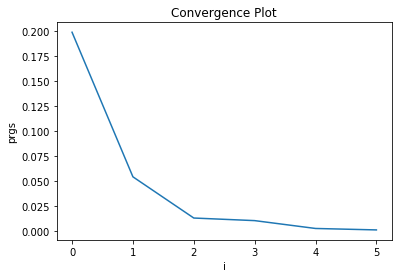

In [21]:
%matplotlib inline
prgrs = [p for p in prgrs if p<1]
plt.plot(prgrs)
plt.title('Convergence Plot')
plt.xlabel('i')
plt.ylabel('prgs')
plt.show()

## Discussions